In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations

import matplotlib.pyplot as plt

### Data

In [2]:
from scipy.stats import pearsonr
import seaborn as sns
from random import sample, seed

In [3]:
working_dir = 'tmp/'

# File inputs
# x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
x_input = 'data/train_protein_matrix.csv'
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'

test_input = 'data/test_protein_matrix.csv'

interaction_input = 'tmp/final3_aux.tsv'


In [4]:
x = pd.read_csv(x_input)

y = pd.read_csv(y_input, usecols=['drug_id','cell_line_name','ln_IC50', 'max_screening_conc'])
y = y[[c for c in y if c != 'ln_IC50'] + ['ln_IC50']]

print("loading data:", test_input)
x_test = pd.read_csv(test_input)

loading data: data/test_protein_matrix.csv


In [5]:
to_scramble = x[x.columns[1:]].to_numpy()
o_dim = to_scramble.shape
to_scramble = to_scramble.reshape(-1)
print(to_scramble)
np.random.shuffle(to_scramble)
print(to_scramble)
scramble = to_scramble.reshape(o_dim)

[7.10954535 3.41494105        nan ...        nan        nan        nan]
[3.71536094        nan        nan ... 7.55729871        nan        nan]


In [6]:
x[x.columns[1:]] = scramble

In [26]:
x

,Cell_Line,P37108.SRP14_HUMAN,Q96JP5.ZFP91_HUMAN,Q9Y4H2.IRS2_HUMAN,P36578.RL4_HUMAN,Q6SPF0.SAMD1_HUMAN,O76031.CLPX_HUMAN,Q8WUQ7.CATIN_HUMAN,A6NIH7.U119B_HUMAN,Q9BTD8.RBM42_HUMAN,...,P33151.CADH5_HUMAN,Q5EBL4.RIPL1_HUMAN,P49715.CEBPA_HUMAN,Q5TA45.INT11_HUMAN,O14924.RGS12_HUMAN,Q7Z3B1.NEGR1_HUMAN,O60669.MOT2_HUMAN,Q13571.LAPM5_HUMAN,Q96JM2.ZN462_HUMAN,P35558.PCKGC_HUMAN
0,K052,NaN,4.929402,8.004404,NaN,1.144421,NaN,3.574096,NaN,NaN,...,4.436789,4.620690,4.334215,6.092690,4.131182,2.619486,4.017847,NaN,4.804563,NaN
1,TE-12,6.009653,6.154423,3.485806,8.321176,3.667042,NaN,NaN,NaN,5.947554,...,5.768915,NaN,NaN,NaN,10.667845,3.099953,NaN,5.031965,2.365907,5.317815
2,TMK-1,4.848174,NaN,NaN,4.815965,NaN,3.459160,3.234122,3.034205,3.418693,...,NaN,2.433190,3.841091,6.194678,3.787055,NaN,4.110621,2.714184,NaN,3.553993
3,STS-0421,4.594441,7.968016,5.350268,2.764335,5.674240,NaN,6.208650,NaN,NaN,...,5.670244,NaN,4.403562,2.991663,2.866235,5.731136,8.527055,NaN,NaN,3.054413
4,PL4,6.739053,NaN,6.265790,3.403826,4.141028,3.399104,4.208503,NaN,4.095387,...,5.395807,NaN,NaN,4.310355,NaN,10.971454,4.253512,NaN,2.620276,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,BE-13,NaN,6.709596,9.238373,NaN,3.601286,2.387853,2.622544,3.466446,NaN,...,7.342526,2.649687,NaN,2.548505,5.166112,2.432302,3.307832,5.412707,NaN,2.664151
755,H9,2.974064,1.444923,3.051184,NaN,3.591991,7.674403,NaN,NaN,NaN,...,NaN,NaN,NaN,4.306652,2.789480,NaN,6.987776,8.736715,NaN,NaN
756,GR-ST,NaN,3.482400,3.455776,NaN,NaN,NaN,4.349766,4.710933,NaN,...,3.520311,5.574086,6.413635,4.988744,NaN,5.843853,2.933494,NaN,NaN,NaN
757,YMB-1-E,4.742852,NaN,3.109887,10.326661,NaN,NaN,5.664830,4.831515,NaN,...,3.502657,2.982236,NaN,3.213678,3.984745,NaN,4.108075,7.085648,2.772606,NaN


In [7]:
tested_regression = pd.read_csv(interaction_input, sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])

C:\Users\wen068\AppData\Local\Temp\ipykernel_9584\2839908837.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  tested_regression = pd.read_csv(interaction_input, sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])


In [8]:
tested_mask = tested_regression.order == tested_regression.coef_id.str.count(":")+1
interactions = tested_regression[tested_mask]

In [24]:
interactions[interactions['P>|z|']< 0.05]

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,standard_fitting,snps,order,drug
19,OjfiibTXDbcHUMAN:QbafijBSTcHUMAN,-0.549450,0.152,-3.624144,0.000382,-0.848702,-0.250198,176,0.108532,True,O95881.TXD12_HUMAN+Q10589.BST2_HUMAN,2,3
63,OedhjfMYObBHUMAN:PaebidKITHHUMAN,-0.499558,0.225,-2.218813,0.028145,-0.944769,-0.054346,141,0.046890,True,O43795.MYO1B_HUMAN+P04183.KITH_HUMAN,2,3
75,PbbebdGgPDHUMAN:PgbccfRAPcBHUMAN,-0.494371,0.165,-3.000220,0.003076,-0.819493,-0.169250,186,0.048494,True,P11413.G6PD_HUMAN+P61225.RAP2B_HUMAN,2,3
83,PaihchKbCbjHUMAN:QjUMXfNENFHUMAN,-0.097265,0.044,-2.199397,0.029013,-0.184477,-0.010053,201,0.030547,True,P08727.K1C19_HUMAN+Q9UMX5.NENF_HUMAN,2,3
91,PffbefMANFHUMAN:QjUMXfNENFHUMAN,-0.346805,0.150,-2.313115,0.021346,-0.641770,-0.051839,326,0.055095,True,P55145.MANF_HUMAN+Q9UMX5.NENF_HUMAN,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10771266,PcicjaITPIcHUMAN:PhidhbTCPBHUMAN:QjBVQhSPAfLHU...,-0.006748,0.003,-2.510656,0.012527,-0.012035,-0.001461,338,0.152788,True,P28290.ITPI2_HUMAN+P78371.TCPB_HUMAN+Q9BVQ7.SP...,4,1973
10771287,PcgaagITAdHUMAN:QiWUYbTHEMgHUMAN:QjjiciCIBbHUM...,-0.004123,0.002,-2.039282,0.042821,-0.008111,-0.000135,195,0.161154,True,P26006.ITA3_HUMAN+Q8WUY1.THEM6_HUMAN+Q99828.CI...,4,1973
10771371,PbedhdTRIchHUMAN:PechgfTHIMHUMAN:QbcjjgCSTFdHU...,-0.012376,0.006,-2.245624,0.025979,-0.023252,-0.001499,182,0.123411,True,P14373.TRI27_HUMAN+P42765.THIM_HUMAN+Q12996.CS...,4,1973
10771392,PaghdaIFeEHUMAN:PbccgiIMDHcHUMAN:QjgDBfRMDbHUM...,-0.002498,0.001,-2.010075,0.044873,-0.004940,-0.000057,603,0.238394,True,P06730.IF4E_HUMAN+P12268.IMDH2_HUMAN+Q96DB5.RM...,4,1973


In [9]:
drug_list = np.unique(interactions.drug)

### Regression

#### Functions

In [10]:
def results_fit_to_df(results, ols, y, test_data):
    coeffs = results.params.tolist()
    pvals = results.pvalues.tolist()
    pseudo_r2 = results.rsquared
    adj_r2 = results.rsquared_adj
    tvals = results.tvalues.tolist()
    cint_low = results.conf_int()[0].tolist()
    cint_high = results.conf_int()[1].tolist()

    pred_y = results.predict()
    train_pear_R = pearsonr(pred_y, y)
    train_mse = np.square(y - pred_y).mean()

    test_y = test_data.lnICfa.to_list()
    pred_y = results.predict(test_data)
    test_pear_R = pearsonr(pred_y, test_y)
    test_mse = np.square(test_y - pred_y).mean()

    
    try:
        results = results.summary()
    except:
        #ValueError: resids must contain at least 2 elements
        r = pd.DataFrame([1,2,3]) #dirty...
        r['z']='nan'
        return r
    converged = results.tables[0].data[5][1].strip()
    results = results.tables[1].data
    results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
    results['P>|z|'] = pvals
    results['z'] = tvals 
    results['coef'] = coeffs
    results['converged'] = converged
    results['pseudo_r2'] = pseudo_r2
    results['adj_r2'] = adj_r2
    results["train_MSE"] = train_mse
    results["MSE"] = test_mse
    results['[0.025'] = cint_low
    results['0.975]'] = cint_high
    results["train_pearsonR"] = train_pear_R.statistic
    results["pearsonR"] = test_pear_R.statistic
    return results

In [11]:
def regression_per_drug(interactions, drug_list, alpha=0.05, filter=0):
    final_results = []
    j = 0
    for i,d in enumerate(drug_list):
        xy = x.merge(y[y["drug_id"]==d], left_on='Cell_Line', right_on='cell_line_name')
        xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns] 

        test_xy = x_test.merge(y[y["drug_id"] == d], left_on='Cell_Line', right_on='cell_line_name')
        test_xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x_test.replace('_','').replace('.','')]) for x_test in test_xy.columns] 
        
        drug_interactions = interactions[interactions.drug == d].drop_duplicates(ignore_index=True)
        sig = fdrcorrection(drug_interactions["P>|z|"], alpha=alpha, method='indep', is_sorted=False)[0]
        
        drug_interactions = drug_interactions[sig]
        sig_interactions = drug_interactions[np.abs(drug_interactions.coef)>=filter][["coef_id", "order"]]
        # sig_interactions["coef_id"] = sig_interactions["coef_id"].str.strip("\[01\]")
        protein_list = np.unique([y for x in sig_interactions.coef_id for y in x.split(":")]).tolist()  # all proteins used in significant synergies of that drug
        print("for drug", d, "reduced from", drug_interactions.shape[0], "to", sig_interactions.shape[0], "with", len(protein_list), "proteins")
        
        data = xy[["lnICfa", "maxscreeningconc"] + protein_list].fillna(0)
        test_data = test_xy[["lnICfa", "maxscreeningconc"] + protein_list].fillna(0)
        print(test_data.shape, data.shape)
        del xy, test_xy
        # with each interration add more interaction information to the regression formula
        for o in [1,5]: # TODO add 2 as layer
            # print("Order: ", o)
            excluded = sig_interactions.coef_id[sig_interactions.order<=o].drop_duplicates(ignore_index=True).to_list() + protein_list
            included = []
            print("number of possible variables:", len(excluded))
            seed(42)
            while excluded and len(included) < 100:
                p_vals = []
                sub_set = [excluded[i] for i in sample(range(len(excluded)), np.min([200, len(excluded)]))] # maybe increase to 500?
                for variable in sub_set:
                    formular = "lnICfa" + " ~ maxscreeningconc + "
                    formular = formular + " + ".join(included + [variable])
            
                    results = smf.ols(formular, data=data).fit(disp=False, maxiter=1000)
                    p_vals.append(results.pvalues[variable])
                best_p = np.min(p_vals)
                if best_p < alpha:
                    i = np.argmin(p_vals)
                    # print('Add {} with p-value {}'.format(sub_set[i], best_p))
                    included.append(sub_set[i])
                    excluded.remove(sub_set[i])
                else:
                    print(best_p)
                    break
                # backward
                formular = "lnICfa" + " ~ maxscreeningconc + "
                formular = formular + " + ".join(included)
                results = smf.ols(formular, data=data).fit(disp=False, maxiter=1000)
                worst_p = np.max(results.pvalues)
                i = np.argmax(results.pvalues) - 2  #  (intercept and maxscreen)
                if i <= 0: continue
                if worst_p > alpha:
                    # print('Remove {} with p-value {}'.format(included[i], worst_p))
                    del included[i]
            formular = "lnICfa" + " ~ maxscreeningconc + "
            formular = formular + " + ".join(included)
            
            try:
                ols = smf.ols(formular,data=data)
            except Exception as inst:
                print(type(inst))
                print('error in OLS, drug', d, "order: ", o, "number of variables (+)", formular.count('+') )
                print(sig_interactions.shape, len(protein_list))
                j += 1
                
                break  # we do not need to check any higher order, if the lower order already fails due to recursion depth
            ols.raise_on_perfect_prediction = False #preventing the perfect separation error
            results = ols.fit(maxiter=100) #method prevents singular matrix
            results = results_fit_to_df(results, ols, data["lnICfa"].to_list(), test_data)
            results["order"] = o
            results["drug"] = d
            results["n_prot"] = len(protein_list) 
            results["n_obs"] = len(data.lnICfa)
            results["n_feat"] = len(included)
            final_results.append(results)
    final_results = pd.concat(final_results)
    print(j/(len(drug_list)), " % of drugs failed OLS at some point")        
    print("The largest amount of features used for a regression was: ", final_results.n_feat.max())
    return final_results

#### Results

In [55]:
len(coef_05[["drug"]].drop_duplicates()), len(drug_list)

(75, 79)

Drugs with error/ols problems: 233, 273, 333, 1003, 1013

In [12]:
coef_05 = regression_per_drug(interactions, [233, 273, 333, 1003, 1403], filter=0.5) #, 1013

for drug 233 reduced from 0 to 0 with 0 proteins
(0, 2) (0, 2)
number of possible variables: 0
<class 'patsy.PatsyError'>
error in OLS, drug 233 order:  1 number of variables (+) 1
(0, 2) 0
for drug 273 reduced from 2907 to 751 with 819 proteins
(174, 821) (688, 821)
number of possible variables: 819
0.05889658235055523
number of possible variables: 1570
0.06302904591802393
for drug 333 reduced from 9151 to 404 with 476 proteins
(175, 478) (702, 478)
number of possible variables: 476
0.07804373579748956
number of possible variables: 880
0.0594104767025471
for drug 1003 reduced from 4140 to 1009 with 1095 proteins
(188, 1097) (756, 1097)
number of possible variables: 1095
0.058477666668944786
number of possible variables: 2104
for drug 1403 reduced from 701 to 145 with 134 proteins
(182, 136) (709, 136)
number of possible variables: 134
0.054016746429268785
number of possible variables: 279
0.057621931834846304
0.2  % of drugs failed OLS at some point
The largest amount of features used

In [14]:
coef_05[["adj_r2", "pseudo_r2", 'train_MSE', 'MSE', 'pearsonR', 'train_pearsonR', 'drug', 'n_prot', 'n_feat']].drop_duplicates(ignore_index=True)

,adj_r2,pseudo_r2,train_MSE,MSE,pearsonR,train_pearsonR,drug,n_prot,n_feat
0,0.202395,0.233742,2.208365,4.144887,-0.260971,0.483469,273,819,27
1,0.276878,0.314771,1.974839,8.069965,-0.060153,0.561044,273,819,36
2,0.173195,0.200322,0.822435,1.535310,0.040290,0.447574,333,476,23
3,0.262217,0.298001,0.721977,4.839853,-0.278194,0.545894,333,476,34
4,0.350391,0.403736,2.030351,4.763815,0.199202,0.635402,1003,1095,62
5,0.544552,0.604876,1.345444,13.652142,-0.155011,0.777738,1003,1095,100
6,0.060096,0.072044,0.870410,0.490062,0.140054,0.268410,1403,134,9
7,0.101374,0.119144,0.826231,0.674249,0.226221,0.345172,1403,134,14


In [22]:
coef_05[coef_05.coef_id.apply(lambda x: x.count(':') > 0)].groupby('drug').size()

drug
273     16
333     14
1003    46
1403     6
dtype: int64

In [18]:
coef_05[["adj_r2", "pseudo_r2", 'train_MSE', 'MSE', 'pearsonR', 'train_pearsonR', 'drug', 'n_prot']].drop_duplicates(ignore_index=True)

,adj_r2,pseudo_r2,train_MSE,MSE,pearsonR,train_pearsonR,drug,n_prot
0,NaN,1.000000,3.741299e-27,19.797882,0.113822,1.000000,273,819
1,0.482801,0.833995,1.707295e-01,2.647130,0.264800,0.913233,333,476
2,NaN,1.000000,1.944908e-26,6.842633,0.058441,1.000000,333,476
3,NaN,1.000000,8.996787e-28,9.352385,0.351122,1.000000,1003,1095
4,0.258834,0.399111,5.636250e-01,0.620222,0.370182,0.631753,1403,134
5,0.505561,0.700404,2.810171e-01,0.753289,0.318975,0.836901,1403,134


In [12]:
coef_05.to_csv(working_dir+"coef_05.csv", index=False)

<Axes: xlabel='n_prot', ylabel='pseudo_r2'>

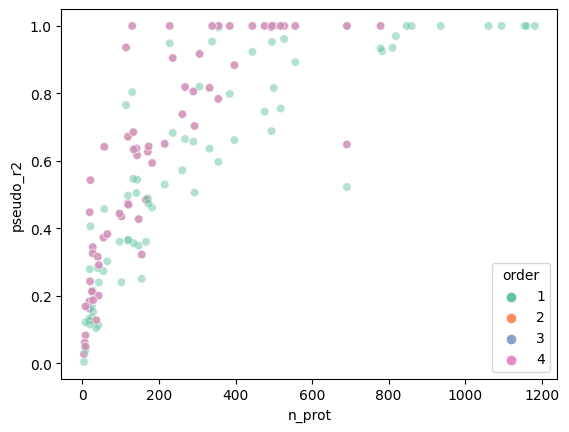

In [48]:
sns.scatterplot(data=coef_05[["adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="pseudo_r2", hue="order", palette="Set2", alpha=0.5)

<Axes: xlabel='n_prot', ylabel='pearsonR'>

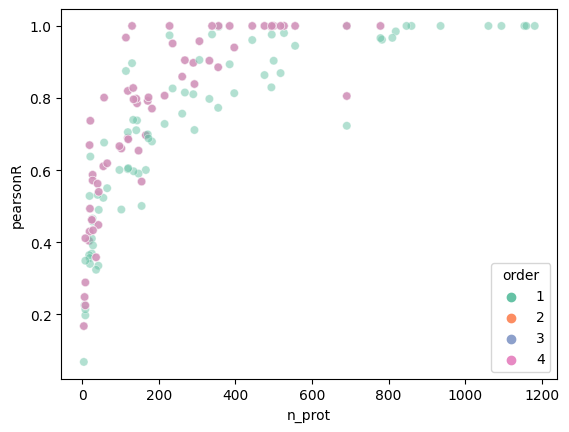

In [29]:
sns.scatterplot(data=coef_05[["pearsonR", "adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="pearsonR", hue="order", palette="Set2", alpha=0.5)

<Axes: xlabel='n_prot', ylabel='adj_r2'>

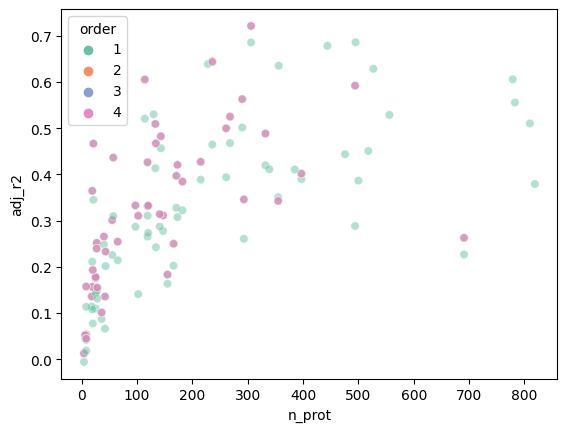

In [34]:
# adj includes nan if to few observations for amount of variables
sns.scatterplot(data=coef_05[["adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="adj_r2", hue="order", palette="Set2", alpha=0.5) 

In [13]:
baseline = regression_per_drug(interactions, drug_list)

for drug 3 reduced from 15 to 15
for drug 53 reduced from 3 to 3
for drug 63 reduced from 6 to 6
for drug 83 reduced from 17 to 17
for drug 133 reduced from 30 to 30
for drug 153 reduced from 28 to 28
for drug 163 reduced from 45 to 45
for drug 173 reduced from 595 to 595


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 193 reduced from 881 to 881
error in OLS, drug 193 order:  2 number of variables (+) 1721
(881, 2) 848
for drug 203 reduced from 3294 to 3294
error in OLS, drug 203 order:  1 number of variables (+) 1947
(3294, 2) 1948
for drug 223 reduced from 1754 to 1754


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 223 order:  2 number of variables (+) 3165
(1754, 2) 1415
for drug 253 reduced from 4571 to 4571
error in OLS, drug 253 order:  1 number of variables (+) 2293
(4571, 2) 2294
for drug 263 reduced from 1987 to 1987


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 263 order:  2 number of variables (+) 3456
(1987, 2) 1474
for drug 273 reduced from 2907 to 2907
error in OLS, drug 273 order:  1 number of variables (+) 1828
(2907, 2) 1829
for drug 283 reduced from 629 to 629


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 293 reduced from 43 to 43
for drug 303 reduced from 5798 to 5798
error in OLS, drug 303 order:  1 number of variables (+) 2589
(5798, 2) 2590
for drug 333 reduced from 9151 to 9151
error in OLS, drug 333 order:  1 number of variables (+) 2903
(9151, 2) 2904
for drug 363 reduced from 536 to 536


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 563 reduced from 162 to 162
for drug 573 reduced from 151 to 151
for drug 1003 reduced from 4140 to 4140
error in OLS, drug 1003 order:  1 number of variables (+) 2284
(4140, 2) 2285
for drug 1013 reduced from 31476 to 31476
error in OLS, drug 1013 order:  1 number of variables (+) 4074
(31476, 2) 4075
for drug 1023 reduced from 133 to 133
for drug 1033 reduced from 15015 to 15015
error in OLS, drug 1033 order:  1 number of variables (+) 3489
(15015, 2) 3490
for drug 1043 reduced from 2611 to 2611
error in OLS, drug 1043 order:  1 number of variables (+) 1663
(2611, 2) 1664
for drug 1053 reduced from 9030 to 9030
error in OLS, drug 1053 order:  1 number of variables (+) 3135
(9030, 2) 3136
for drug 1073 reduced from 3556 to 3556
error in OLS, drug 1073 order:  1 number of variables (+) 2040
(3556, 2) 2041
for drug 1083 reduced from 5125 to 5125
error in OLS, drug 1083 order:  1 number of variables (+) 2372
(5125, 2) 2373
for drug 1093 reduced from 5240 to 5240
error in OLS, dr

C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 1243 reduced from 265 to 265
for drug 1263 reduced from 832 to 832


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1263 order:  2 number of variables (+) 1728
(832, 2) 899
for drug 1373 reduced from 8902 to 8902
error in OLS, drug 1373 order:  1 number of variables (+) 3381
(8902, 2) 3382
for drug 1393 reduced from 1242 to 1242


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1393 order:  2 number of variables (+) 2354
(1242, 2) 1117
for drug 1403 reduced from 701 to 701


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 1413 reduced from 860 to 860


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1413 order:  2 number of variables (+) 1749
(860, 2) 896
for drug 1433 reduced from 1149 to 1149


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1433 order:  2 number of variables (+) 2177
(1149, 2) 1037
for drug 1453 reduced from 1875 to 1875


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1453 order:  2 number of variables (+) 3299
(1875, 2) 1434
for drug 1463 reduced from 496 to 496


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 1543 reduced from 99 to 99
for drug 1553 reduced from 50 to 50
for drug 1563 reduced from 7592 to 7592
error in OLS, drug 1563 order:  1 number of variables (+) 2708
(7592, 2) 2709
for drug 1593 reduced from 318 to 318


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 1613 reduced from 16 to 16
for drug 1633 reduced from 1104 to 1104


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1633 order:  2 number of variables (+) 2105
(1104, 2) 1003
for drug 1793 reduced from 157 to 157


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 1853 reduced from 0 to 0
error in OLS, drug 1853 order:  1 number of variables (+) 0
(0, 2) 0
for drug 1873 reduced from 2211 to 2211
error in OLS, drug 1873 order:  1 number of variables (+) 1692
(2211, 2) 1693
for drug 1913 reduced from 4213 to 4213
error in OLS, drug 1913 order:  1 number of variables (+) 2188
(4213, 2) 2189
for drug 1923 reduced from 10 to 10
for drug 1933 reduced from 4221 to 4221
error in OLS, drug 1933 order:  1 number of variables (+) 2247
(4221, 2) 2248
for drug 1973 reduced from 1596 to 1596


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1973 order:  2 number of variables (+) 2939
(1596, 2) 1357
for drug 1993 reduced from 1726 to 1726


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1993 order:  2 number of variables (+) 3113
(1726, 2) 1398
for drug 2013 reduced from 465 to 465


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 2023 reduced from 3792 to 3792
error in OLS, drug 2023 order:  1 number of variables (+) 2010
(3792, 2) 2011
for drug 2043 reduced from 4975 to 4975
error in OLS, drug 2043 order:  1 number of variables (+) 2385
(4975, 2) 2386
for drug 2063 reduced from 825 to 825


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2063 order:  2 number of variables (+) 1666
(825, 2) 843
for drug 2093 reduced from 423 to 423


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 2103 reduced from 1628 to 1628


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2103 order:  2 number of variables (+) 2709
(1628, 2) 1095
for drug 2153 reduced from 2365 to 2365
error in OLS, drug 2153 order:  1 number of variables (+) 1624
(2365, 2) 1625
for drug 2163 reduced from 3427 to 3427
error in OLS, drug 2163 order:  1 number of variables (+) 1852
(3427, 2) 1853
for drug 2173 reduced from 6214 to 6214
error in OLS, drug 2173 order:  1 number of variables (+) 2589
(6214, 2) 2590
for drug 2183 reduced from 147 to 147


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 2243 reduced from 489 to 489


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 2253 reduced from 80 to 80
for drug 2273 reduced from 1698 to 1698


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2273 order:  2 number of variables (+) 3005
(1698, 2) 1316
for drug 2283 reduced from 1441 to 1441


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2283 order:  2 number of variables (+) 2669
(1441, 2) 1233
for drug 2293 reduced from 1663 to 1663


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2293 order:  2 number of variables (+) 2791
(1663, 2) 1131
for drug 2303 reduced from 468 to 468


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

for drug 2313 reduced from 758 to 758


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2313 order:  2 number of variables (+) 1572
(758, 2) 820
for drug 2323 reduced from 1534 to 1534


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2323 order:  2 number of variables (+) 2699
(1534, 2) 1174
for drug 2333 reduced from 1608 to 1608


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2333 order:  2 number of variables (+) 2879
(1608, 2) 1285
for drug 2363 reduced from 860 to 860


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2363 order:  2 number of variables (+) 1617
(860, 2) 763
for drug 2463 reduced from 2 to 2
for drug 2503 reduced from 4393 to 4393
error in OLS, drug 2503 order:  1 number of variables (+) 2250
(4393, 2) 2251
0.5949367088607594  % of drugs failed OLS at some point
The largest amount of proteins used for a regression was:  1474


In [28]:
len(baseline[["drug"]].drop_duplicates())

52

In [14]:
baseline.to_csv(working_dir+"baseline.csv", index=False)

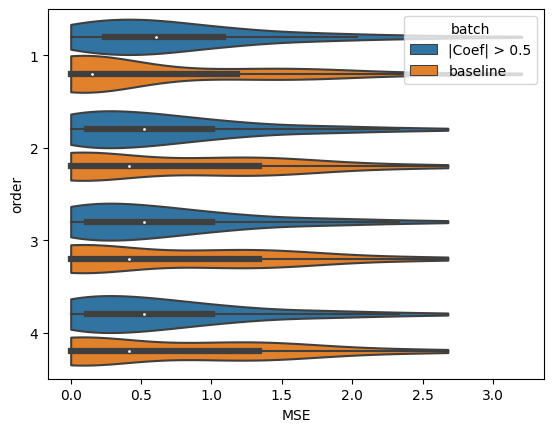

In [15]:
coef_05["batch"] = "|Coef| > 0.5"
baseline["batch"] = "baseline"

combined = pd.concat([coef_05, baseline], ignore_index=True)
combined = combined[["MSE", "pearsonR", "order", "drug", "batch"]].drop_duplicates(ignore_index=True)
sns.violinplot(data=combined, x="MSE", y="order", hue="batch", cut=0, orient="h" )
plt.savefig(working_dir+"img/mse.png")